# DenseNet

回想一下任意函数的泰勒展开式(Taylor expansion)，它把这个函数分解成越来越高阶的项。在x接近0时

$$
f(x) = f(0) + f^{'}(0)x + \frac{f^{''}(0)x^2 }{2!}+\frac{f^{'''}(0)x^3 }{3!} + ···
$$

同样，ResNet将函数展开为

$$
f(\pmb x) = \pmb x + g(\pmb x)
$$

也就是说，ResNet将f 分解为两部分:一个简单的线性项和一个复杂的非线性项。那么再向前拓展一步，如
果我们想将f 拓展成超过两部分的信息呢?一种方案便是DenseNet。
![title](attachment/densenet.png)

ResNet和DenseNet的关键区别在于，DenseNet输出是连接(用图中的[,]表示)而不是
如ResNet的简单相加。因此，在应用越来越复杂的函数序列后，我们执行从x到其展开式的映射:

$$x → [\pmb x, f_1(\pmb x), f_2([\pmb x, f_1(\pmb x)]), f_3([\pmb x, f_1(\pmb x), f_2([\pmb x, f_1(\pmb x)])]), . . .]$$

![title](attachment/densenet2.png)

ps：

pip install d2l

pip install matplotlib==3.0.0

In [1]:
import os
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
import matplotlib.pyplot as plt

## Dense Block


In [2]:
def conv_block(input_channels, num_channels):
  return nn.Sequential(
      nn.BatchNorm2d(input_channels), nn.ReLU(),
      nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
  )

In [3]:
class DenseBlock(nn.Module):
  def __init__(self, num_convs, input_channels, num_channels):
    super().__init__()
    layer = []
    for i in range(num_convs):
      layer.append(conv_block(
          num_channels * i + input_channels, num_channels
      ))
    self.net = nn.Sequential(*layer)

  def forward(self, X):
    for blk in self.net:
      Y = blk(X)
      X = torch.cat((X, Y), dim=1)
    return X

In [4]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

- Transition Block

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。而过渡层可以用来控制模型复杂度。

它通过1 × 1卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。


In [5]:
def transition_block(input_channels, num_channels): 
  return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [6]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## DenseNet

接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。与ResNet类似，我们可以设置每个
稠密块使用多少个卷积层。这里我们设成4，从而与 7.6节的ResNet-18保持一致。稠密块里的卷积层通道数 (即增⻓率)设为32，所以每个稠密块将增加128个通道。

在每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半 通道数。

In [7]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [8]:
num_channels, growth_rate = 64, 32 
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []

for i, num_convs in enumerate(num_convs_in_dense_blocks):
  blks.append(DenseBlock(num_convs, num_channels, growth_rate)) 
  # 上一个稠密块的输出通道数
  num_channels += num_convs * growth_rate
  # 在稠密块之间添加一个转换层，使通道数量减半
  if i != len(num_convs_in_dense_blocks) - 1: 
    blks.append(transition_block(num_channels, num_channels // 2)) 
    num_channels = num_channels // 2

In [9]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

In [10]:
X = torch.randn(64, 1, 96, 96)
for layer in net: 
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([64, 64, 24, 24])
DenseBlock output shape:	 torch.Size([64, 192, 24, 24])
Sequential output shape:	 torch.Size([64, 96, 12, 12])
DenseBlock output shape:	 torch.Size([64, 224, 12, 12])
Sequential output shape:	 torch.Size([64, 112, 6, 6])
DenseBlock output shape:	 torch.Size([64, 240, 6, 6])
Sequential output shape:	 torch.Size([64, 120, 3, 3])
DenseBlock output shape:	 torch.Size([64, 248, 3, 3])
BatchNorm2d output shape:	 torch.Size([64, 248, 3, 3])
ReLU output shape:	 torch.Size([64, 248, 3, 3])
AdaptiveAvgPool2d output shape:	 torch.Size([64, 248, 1, 1])
Flatten output shape:	 torch.Size([64, 248])
Linear output shape:	 torch.Size([64, 10])


## Train


In [11]:
# 载入数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
# 3. 初始化weight

def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

# 4. 定义loss

l = nn.CrossEntropyLoss()

# 5. 定义优化器

o = torch.optim.SGD(net.parameters(), lr=0.05)

In [13]:
# 6. Train
def acc(X,y,net):
  p_predict = net(X)
  y_predict = torch.argmax(p_predict,axis=1)
  output = y_predict - y
  right_pre = len(output[output==0])
  right_accu = right_pre/len(output)
  return right_accu

def eval_accu(net=None, dataset=None, cuda=False):
  accu = 0
  batch = 0
  net.eval()

  for X,y in dataset:
    if cuda:
      net.cuda()
      X,y = X.cuda(),y.cuda()
    accu += acc(X, y, net)
    batch += 1
  avg_acc = accu/batch
  return avg_acc

def train_net(net=None, epochs=10, loss = None, optimizer=None, 
              train_iter=None, test_iter=None, cuda=False):
  train_accu_history = []
  test_accu_history = []
  train_loss = []

  for epoch in range(epochs):

    net.train()
    for X,y in train_iter:
      if cuda:
        net.cuda()
        X,y = X.cuda(),y.cuda()
      l = loss(net(X), y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()

    net.eval() 
    l = loss(net(X), y)
    train_loss.append(l.cpu().detach())
    

    train_avg_acc = eval_accu(net, train_iter, cuda)
    test_avg_acc = eval_accu(net, test_iter, cuda)
    train_accu_history.append(train_avg_acc)
    test_accu_history.append(test_avg_acc)

    print(f'epoch {epoch + 1}, loss {l:f}, train_accu {train_avg_acc:f}, test_accu {test_avg_acc:f}')
  
  x_label_value = [str(i) for i in range(1,epochs+1)]
  plt.plot(x_label_value, train_accu_history, label='train_accu', color='g', linestyle='dashed')
  plt.plot(x_label_value, test_accu_history, label='test_accu', color='r', linestyle='dashed')
  plt.plot(x_label_value, train_loss, label='train_loss', color='b')
  plt.xlabel('epoch')
  plt.ylim(0.1,2)
  plt.legend()
  plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, loss 0.263736, train_accu 0.836630, test_accu 0.836824
epoch 2, loss 0.214977, train_accu 0.870313, test_accu 0.870340
epoch 3, loss 0.315730, train_accu 0.801313, test_accu 0.801313
epoch 4, loss 0.479373, train_accu 0.816284, test_accu 0.816201
epoch 5, loss 0.209065, train_accu 0.881643, test_accu 0.881588
epoch 6, loss 0.127758, train_accu 0.897778, test_accu 0.897557
epoch 7, loss 0.164139, train_accu 0.908461, test_accu 0.908322
epoch 8, loss 0.064365, train_accu 0.931715, test_accu 0.931937
epoch 9, loss 0.187993, train_accu 0.881571, test_accu 0.881461
epoch 10, loss 0.131744, train_accu 0.889367, test_accu 0.889617


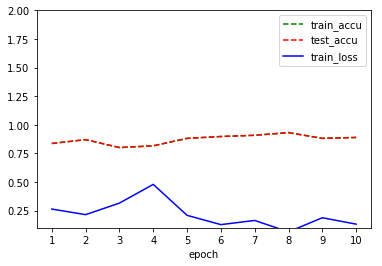

CPU times: user 7min 12s, sys: 22.6 s, total: 7min 35s
Wall time: 10min 1s


In [14]:
%%time
train_net(net=net, epochs=10, loss = l, optimizer=o, 
          train_iter=train_iter, test_iter=train_iter, cuda=True)